# MIDAS soft X-ray toy example

Here we show a toy example of inferring 1D profiles of electron temperature and density based on measurements of the electron pressure profile, the soft X-ray emission profile and a line-integrated density measurement.

First, import and plot the data for the example:

In [1]:
from data import brem_axis, brem_data, brem_sigma
from data import pe_axis, pe_data, pe_sigma
from data import inter_axis, inter_data, inter_sigma

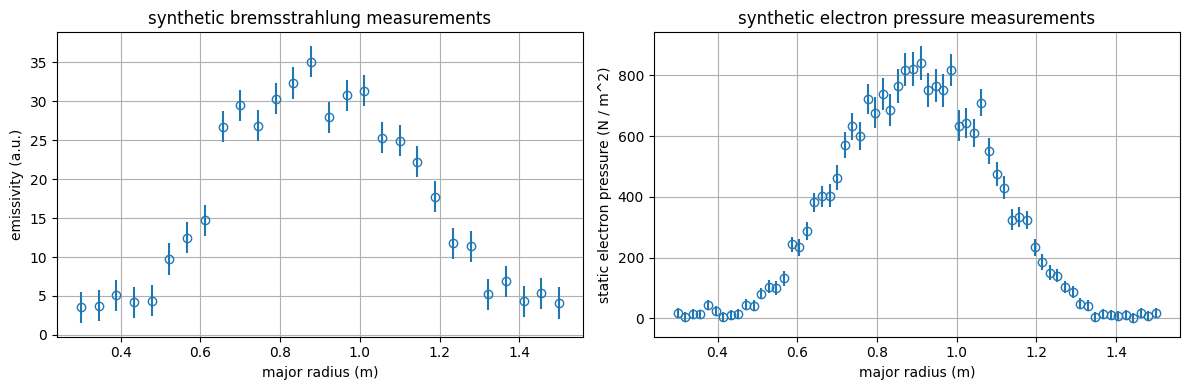

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.errorbar(brem_axis, brem_data, yerr=brem_sigma, ls="none", marker="o", markerfacecolor="none")
ax1.grid()
ax1.set_xlabel("major radius (m)")
ax1.set_ylabel("emissivity (a.u.)")
ax1.set_title("synthetic bremsstrahlung measurements")

ax2 = fig.add_subplot(1, 2, 2)
ax2.errorbar(pe_axis, pe_data, yerr=pe_sigma, ls="none", marker="o", markerfacecolor="none")
ax2.grid()
ax2.set_xlabel("major radius (m)")
ax2.set_ylabel("static electron pressure (N / m^2)")
ax2.set_title("synthetic electron pressure measurements")
plt.tight_layout()
plt.show()

## Defining diagnostic models
In `midas`, models are classes which inherit from an abstract base-class `DiagnosticModel`. This class can fully implement a forward-model of a diagnostic, or act as a light wrapper around a model implemented elsewhere, allowing that model to interact with `midas`. `DiagnosticModel` has two abstract methods, `predictions` and `predictions_and_jacobians`. Any information which the model requires in order to evaluate its predictions is specified using the `FieldRequest` and `ParameterVector` classes.

Here we implement a toy model for bremsstrahlung emission $\mathcal{E}$:
$$
\mathcal{E} = n_e^2\sqrt{T_e} + b
$$
for electron temperature $T_e$, electron density $n_e$ and a background level parameter $b$.

To evaluate the model, we need the values of $T_e$ and $n_e$ at the radial positions of our data. In `midas`, diagnostic models are independent of models for plasma fields like $T_e$, $n_e$, and we request values for these fields using the `FieldRequest` class. Instances of `FieldRequest` are stored as a list assigned to the `field_requests` instance variable of the model class.

Other parameters required by the model, such as the background value in this case, can be specified using the `ParameterVector` class. Instances of `ParameterVector` are stored as a list assigned to the `parameters` instance variable of the model class.

In [3]:
from numpy import ndarray, zeros, fill_diagonal, sqrt, linspace, exp
from midas.models import DiagnosticModel
from midas.parameters import FieldRequest, ParameterVector


class BremsstrahlModel(DiagnosticModel):
    def __init__(self, radius: ndarray):
        # The given 'radius' array specifies the location of the emission measurements,
        # so we use 'FieldRequest' to request the temperature and density at those positions        
        self.field_requests = [
            FieldRequest(name="te", coordinates={"radius": radius}),
            FieldRequest(name="ne", coordinates={"radius": radius}),
        ]
        # The model also requires a background value, so we use 'ParameterVector'
        # to specify a background free parameter:
        self.parameters = [ParameterVector(name="background", size=1)]
        
    def predictions(self, te: ndarray, ne: ndarray, background: float):
        return sqrt(te) * ne**2 + background

    def predictions_and_jacobians(self, te: ndarray, ne: ndarray, background: float):
        predictions = sqrt(te) * ne**2 + background
        # create arrays for the jacobians of the predictions with respect to each input:
        te_jac = zeros([te.size, te.size])
        ne_jac = zeros([te.size, te.size])
        bg_jac = zeros((te.size, 1)) + 1.0
        # calculate the jacobians
        fill_diagonal(te_jac, 0.5*ne**2 / sqrt(te))
        fill_diagonal(ne_jac, 2 * sqrt(te) * ne)
        # The jacobians are returned as a dictionary mapping the input names
        # to the jacobian arrays
        jacobians = {
            "te": te_jac,
            "ne": ne_jac,
            "background": bg_jac
        }
        return predictions, jacobians

Now we import similarly defined models for the electron pressure and density measurements, and create instances of the models:

In [4]:
from models import PressureModel, InterferometerModel

brem_model = BremsstrahlModel(radius=brem_axis)
pe_model = PressureModel(radius=pe_axis)
inter_model = InterferometerModel(radius=inter_axis)

## Building diagnostic likelihoods
For each diagnostic included in the analysis, we create an instance of `DiagnosticLikelihood`, which takes as inputs the model for the diagnostic, a `LikelihoodFunction` and a name to identify the diagnostic.

In [5]:
from midas.likelihoods import DiagnosticLikelihood, GaussianLikelihood

brem_likelihood = DiagnosticLikelihood(
    diagnostic_model=brem_model,
    likelihood=GaussianLikelihood(
        y_data=brem_data,
        sigma=brem_sigma
    ),
    name="bremsstrahlung"
)

inter_likelihood = DiagnosticLikelihood(
    diagnostic_model=inter_model,
    likelihood=GaussianLikelihood(
        y_data=inter_data,
        sigma=inter_sigma
    ),
    name="interferometer"
)

pe_likelihood = DiagnosticLikelihood(
    diagnostic_model=pe_model,
    likelihood=GaussianLikelihood(
        y_data=pe_data,
        sigma=pe_sigma
    ),
    name="pressure"
)

## Adding prior constraints
Custom prior distributions can be easily created by writing a class which inherits from the `midas.priors.BasePrior` abstract base-class. Here we use the `GaussianProcessPrior` which is already available within `midas` to add a smoothness constraint to the electron temperature and density fields:

In [6]:
from midas.priors import GaussianProcessPrior
from inference.gp.covariance import SquaredExponential
from inference.gp.mean import ConstantMean

# choose the radius points for which smoothness is enforced by the GP priors
gp_axis = linspace(0.3, 1.5, 16)

# generate requests for the values of the two fields at these positions
te_gp_positions = FieldRequest(name="te", coordinates={"radius": gp_axis})
ne_gp_positions = FieldRequest(name="ne", coordinates={"radius": gp_axis})

# create the GP prior objects
te_gp = GaussianProcessPrior(
    covariance=SquaredExponential(),
    mean=ConstantMean(),
    field_positions=te_gp_positions,
    name="te_gp"
)

ne_gp = GaussianProcessPrior(
    covariance=SquaredExponential(),
    mean=ConstantMean(),
    field_positions=ne_gp_positions,
    name="ne_gp"
)

## Defining models for plasma fields
As our diagnostic models and priors require information about particular plasma fields, in this case the electron temperature and density, we need to specify models which parametrise those fields in some way. Here we use the built-in `PiecewiseLinearField` model for both fields, which models a 1D field using a set of overlapping basis-function which when summed produce a piecewise-linear function.

Field models in `midas` also have an associated base class, `FieldModel`, which can be used to specify custom models for fields.

In [7]:
from midas.state import PlasmaState
from midas.fields import PiecewiseLinearField

# specify the radial positions for the basis functions
field_axis = linspace(0.3, 1.5, 16)

# build the field models for temperature and density
field_models = [
    PiecewiseLinearField(field_name="te", axis=field_axis, axis_name="radius"),
    PiecewiseLinearField(field_name="ne", axis=field_axis, axis_name="radius"),
]

# pass the models the to the PlasmaState
PlasmaState.specify_field_models(field_models)

## Constructing the posterior
The final step in specifying the posterior distribution is to group all of the components of the posterior and pass them to `PlasmaState.build_parametrisation`:

In [8]:
components = [
    brem_likelihood,
    pe_likelihood,
    inter_likelihood,
    te_gp,
    ne_gp
]

PlasmaState.build_parametrisation(components)

Now the parametrisation has been built sucessfully, we can evaluate the posterior log-probability and its gradient using the `posterior` module:

In [9]:
from midas import posterior

## MAP estimation
Now we are able to evaluate the posterior, the next step is to find the model parameter which maximise the posterior probability.

We can view the names of the parameters in the `PlasmaState.parameter_names` set, or both the names and sizes in the `PlasmaState.parameter_sizes` dictionary:

In [10]:
PlasmaState.parameter_sizes

{'background': 1,
 'ne_gp_cov_hyperpars': 2,
 'ne_gp_mean_hyperpars': 1,
 'ne_linear_basis': 16,
 'te_gp_cov_hyperpars': 2,
 'te_gp_mean_hyperpars': 1,
 'te_linear_basis': 16}

As optimisers and MCMC samplers typically require the parameter values as a single `numpy.ndarray`, `PlasmaState` has methods for converting between dictionaries mapping parameter names to values and the required arrays.

Here we use the `PlasmaState.merge_parameters` method to build an initial guess array for the optimisation:

In [11]:
# generate rough guesses for the temperature and density profile basis functions
te_guess = 500 * exp(-0.5 * ((field_axis - 0.9) / 0.3)**2)
ne_guess = 0.7 * exp(-0.5 * ((field_axis - 0.9) / 0.3)**2)

# merge the initial guesses for each parameter into a single array
initial_guess = PlasmaState.merge_parameters(
    {
        "te_linear_basis": te_guess,
        "ne_linear_basis": ne_guess,
        "background": 3.0,
        "te_gp_cov_hyperpars": [4., -3],
        "ne_gp_cov_hyperpars": [-0.2, -3],
        "te_gp_mean_hyperpars": 0.01,
        "ne_gp_mean_hyperpars": 0.01,
    }
)

We can evaluate the posterior log-probability of our initial guess using the `posterior.log_probability` function:

In [12]:
print(posterior.log_probability(initial_guess))

-1939.4979067856889


Now we can use the same approach to construct lower and upper bounds arrays for the parameters which can be given to the optimiser:

In [13]:
lower_bounds = PlasmaState.merge_parameters(
    {
        "te_linear_basis": 1e-6,
        "ne_linear_basis": 1e-6,
        "background": 1e-6,
        "te_gp_cov_hyperpars": [-2, -5],
        "ne_gp_cov_hyperpars": [-2, -5],
        "te_gp_mean_hyperpars": 0.,
        "ne_gp_mean_hyperpars": 0.,
    }
)

upper_bounds = PlasmaState.merge_parameters(
    {
        "te_linear_basis": 1200.,
        "ne_linear_basis": 10.,
        "background": 20.0,
        "te_gp_cov_hyperpars": [6., -2.5],
        "ne_gp_cov_hyperpars": [3., -2.5],
        "te_gp_mean_hyperpars": 1.,
        "ne_gp_mean_hyperpars": 0.05,
    }
)

As most optimisers are set up to _minimise_ the value of a function, the `posterior` module has `cost` and `cost_gradient` functions which return the negative of the log-probability and its gradient respectively. We can pass these functions to a gradient-based optimiser along with the bounds and intial guess:

In [14]:
from scipy.optimize import minimize
opt_result = minimize(
    fun=posterior.cost,
    x0=initial_guess,
    jac=posterior.cost_gradient,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)]
)

# extract the MAP estimate parameters from the results 
map_estimate_params = opt_result.x

# verify that the MAP parameters yield a higher log-probability than the initial guess
print(f"initial guess log-prob {posterior.log_probability(initial_guess):.2f}")
print(f" MAP estimate log-prob {posterior.log_probability(map_estimate_params):.2f}")

initial guess log-prob -1939.50
 MAP estimate log-prob -432.61


Arrays containing values for all parameters can be split into separate arrays for each parameter using the `PlasmaState.split_parameters` method:

In [15]:
params_dict = PlasmaState.split_parameters(map_estimate_params)

Now we can plot the MAP estimate of the temperature and density profiles, and compare them to the underlying test profiles used to generate the synthetic data:

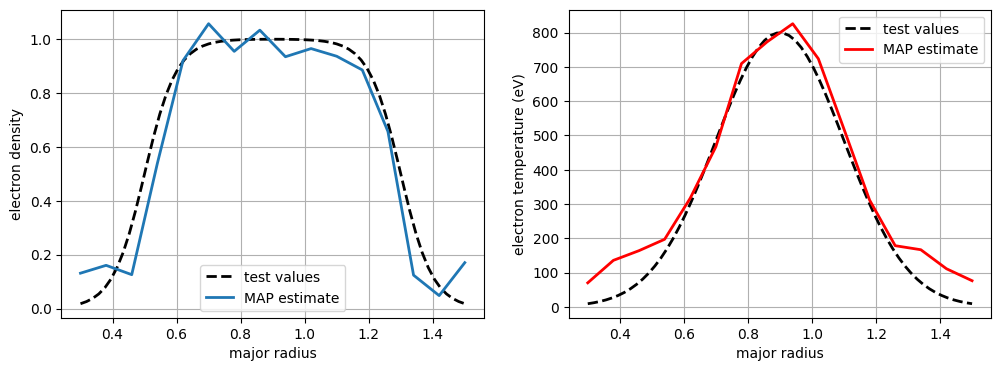

In [16]:
from data import test_axis, test_te, test_ne

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(test_axis, test_ne, label="test values", c="black", lw=2, ls="dashed")
ax1.plot(field_axis, params_dict["ne_linear_basis"], label="MAP estimate", c="C0", lw=2)
ax1.set_ylabel("electron density")
ax1.set_xlabel("major radius")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_axis, test_te, label="test values", c="black", lw=2, ls="dashed")
ax2.plot(field_axis, params_dict["te_linear_basis"], label="MAP estimate", c="red", lw=2)
ax2.set_ylabel("electron temperature (eV)")
ax2.set_xlabel("major radius")
ax2.grid()
ax2.legend()

plt.show()

The `get_model_predictions` function takes in an array of parameter values and returns a dictionary mapping the names of each diagnostic (as they were specified when creating the diagnostic likelihoods) and the predictions of the data for that diagnostic:

In [17]:
model_predictions = posterior.get_model_predictions(map_estimate_params)

# check the diagnostic names
{name for name in model_predictions.keys()}

{'bremsstrahlung', 'interferometer', 'pressure'}

We can now plot the predictions of the diagnostic data from the MAP estimate alongside the synthetic data values:

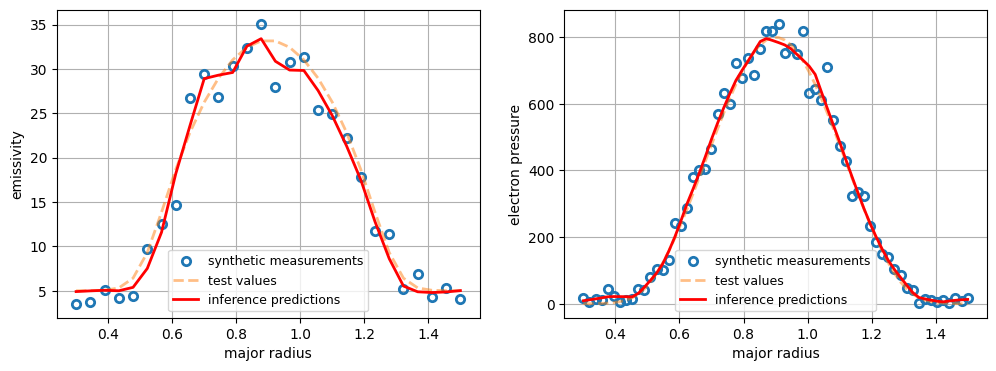

In [18]:
from data import test_axis, test_te, brem_data_clean, pe_data_clean

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(brem_axis, brem_data, "o", label="synthetic measurements", markerfacecolor="none", markeredgewidth=2)
ax1.plot(brem_axis, brem_data_clean, "--", alpha=0.5, lw=2, label="test values")
ax1.plot(brem_axis, model_predictions["bremsstrahlung"], c="red", lw=2, label="inference predictions")
ax1.grid()
ax1.set_ylabel("emissivity")
ax1.set_xlabel("major radius")
ax1.legend(fontsize=9)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(pe_axis, pe_data, "o", label="synthetic measurements", markerfacecolor="none", markeredgewidth=2)
ax2.plot(pe_axis, pe_data_clean, "--", alpha=0.5, lw=2, label="test values")
ax2.plot(pe_axis, model_predictions["pressure"], c="red", lw=2, label="inference predictions")
ax2.grid()
ax2.set_ylabel("electron pressure")
ax2.set_xlabel("major radius")
ax2.legend(fontsize=9)

plt.show()

## Uncertainty quantification using MCMC
To characterise the uncertainies in our model parameters we will sample from the posterior distribution using Hamiltonian Monte Carlo (HMC), an MCMC algorithm which can efficiently sample from high-dimensional posterior distributions, but requires calculation of the gradient of the posterior log-probability.

MIDAS has been intentionally designed to be easily used with external packages for optimisation and sampling. Here we use the [inference-tools](https://github.com/C-bowman/inference-tools) package to perform the MCMC sampling.

First we get the variance of the conditional distribution for each model parameter around the MAP estimate:

In [19]:
from inference.approx import conditional_moments

_, conditional_variances = conditional_moments(
    posterior=posterior.log_probability,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)],
    conditioning_point=map_estimate_params
)

These conditional distribution variances are given as an optional argument to the `HamiltonianChain` class to improve the sampling efficiency (see the [inference-tools docs](https://inference-tools.readthedocs.io/en/stable/HamiltonianChain.html) for details).

Now we can create an instance of the MCMC sampler:

In [20]:
from inference.mcmc import Bounds, HamiltonianChain

hmc_bounds = Bounds(lower=lower_bounds, upper=upper_bounds)

chain = HamiltonianChain(
    posterior=posterior.log_probability,
    start=map_estimate_params,
    bounds=hmc_bounds,
    grad=posterior.gradient,
    epsilon=0.25,
    inverse_mass=conditional_variances,
    display_progress=False
)
chain.steps = 20

To perform the sampling we advance the Markov-chain a given number of steps:

In [21]:
chain.advance(2500)

We can use the `plot_diagnostics` method of markov-chain objects to view key diagnostics of the sampling:

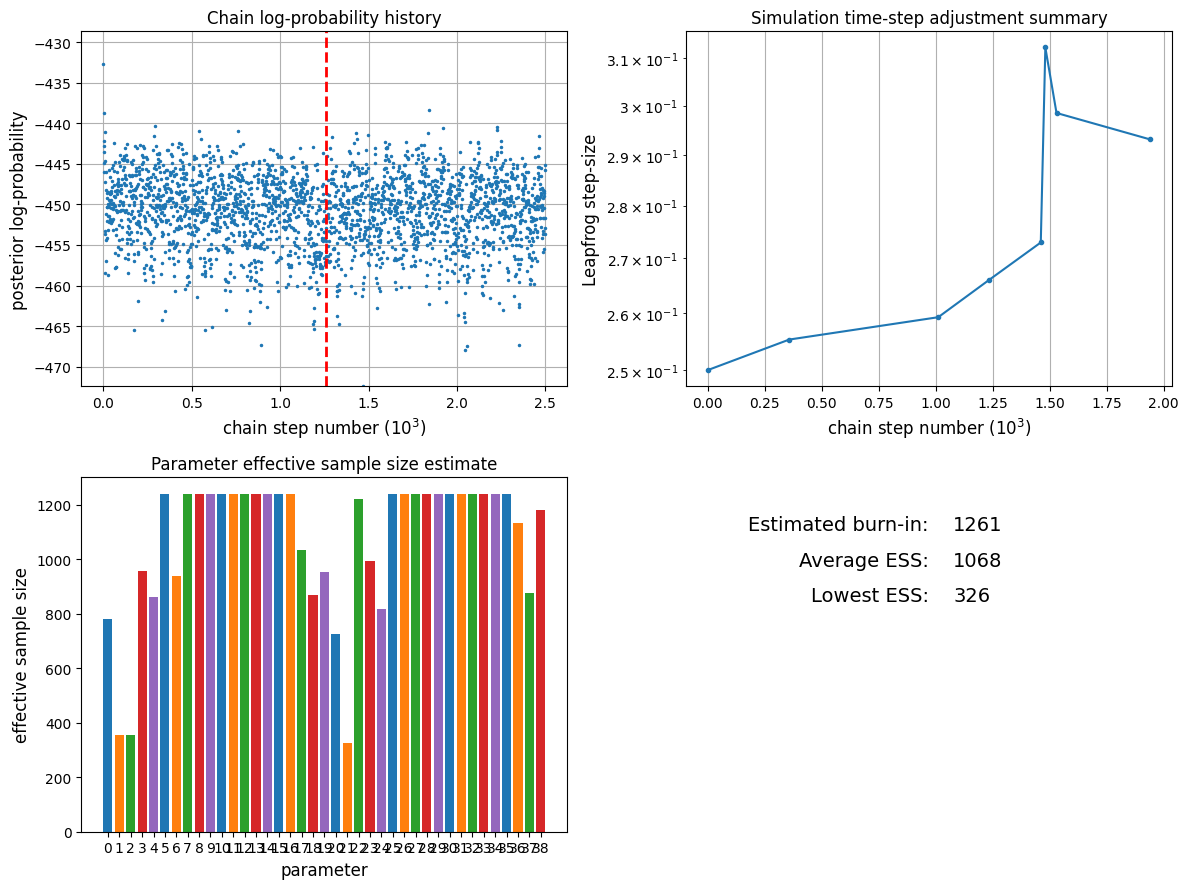

In [22]:
chain.plot_diagnostics()

Retreive the sample data from the chain:

In [23]:
samples = chain.get_sample(burn=500, thin=2)

Similar to the `split_parameters` method, `PlasmaState` also has a `split_samples` method for splitting an array of samples into sub-arrays for each parameter:

In [24]:
samples_dict = PlasmaState.split_samples(parameter_samples=samples)

Now we can calculate the mean and 95% highest-density interval (HDI) for each of the parameters:

In [25]:
from inference.pdf import sample_hdi
samples_hdi_95 = {
    name: sample_hdi(samples, fraction=0.95) for name, samples in samples_dict.items()
}

samples_mean = {name: samples.mean(axis=0) for name, samples in samples_dict.items()}

Finally we can compare the inferred profiles with uncertainties to the test data:

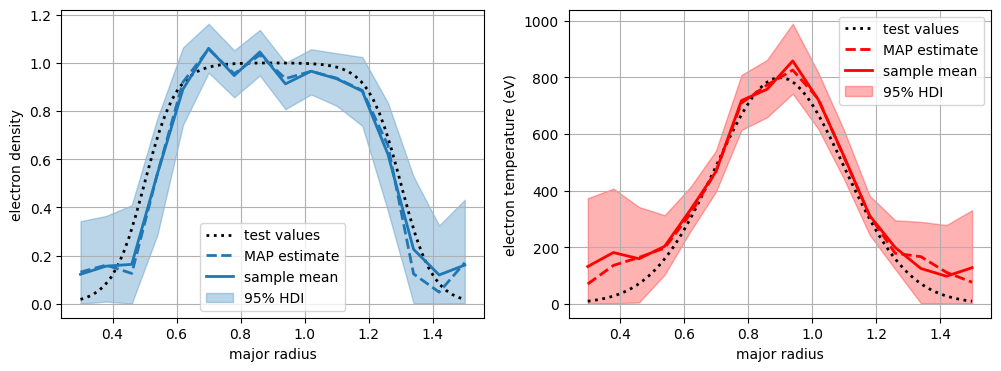

In [26]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(test_axis, test_ne, label="test values", c="black", ls="dotted", lw=2)
ax1.plot(field_axis, params_dict["ne_linear_basis"], label="MAP estimate", c="C0", ls="dashed", lw=2)
ax1.plot(field_axis, samples_mean["ne_linear_basis"], label="sample mean", c="C0", lw=2)
ax1.fill_between(field_axis, *samples_hdi_95["ne_linear_basis"], alpha=0.3, color="C0", label="95% HDI")
ax1.set_ylabel("electron density")
ax1.set_xlabel("major radius")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_axis, test_te, color="black", lw=2, ls="dotted", label="test values")
ax2.plot(field_axis, params_dict["te_linear_basis"], color="red", lw=2, ls="dashed", label="MAP estimate")
ax2.plot(field_axis, samples_mean["te_linear_basis"], color="red", lw=2, label="sample mean")
ax2.fill_between(field_axis, *samples_hdi_95["te_linear_basis"], color="red", alpha=0.3, label="95% HDI")
ax2.set_ylabel("electron temperature (eV)")
ax2.set_xlabel("major radius")
ax2.grid()
ax2.legend()

plt.show()